----------------------------------------------------
Machine Learning     

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* and *Pablo M. Olmos olmos@tsc.uc3m.es*

----------------------------------------------------

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# use seaborn plotting defaults
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = [6,6]

# 1. Introduction to kernel methods

## Review of linear models

Many of the algorithms presented in previous lessons are intended to infer a target variable $y$ (either a label or regressor) from a set of features $\mathbf{x}\in\mathbb{R}^D$, for this purpose, they define a linear model. For instance:
* **Linear regression** estimates the target variable for a new sample $\mathbf{x}^*$ as a linear combination of the input features:

$$\hat{y}^* = f(\mathbf{x}^*) = \mathbf{w}^T\mathbf{x}^*+w_0$$

* Both **logistic regression** and **support vector machines**, to separate the data of one class from the other, define a linear classification boundary given by
$$ f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+w_0=0$$



However, in many situations, the relationships between the observations and the target variables are rather nonlinear and we need models able to capture these relationships.

For instance, consider the following binary classification problem:





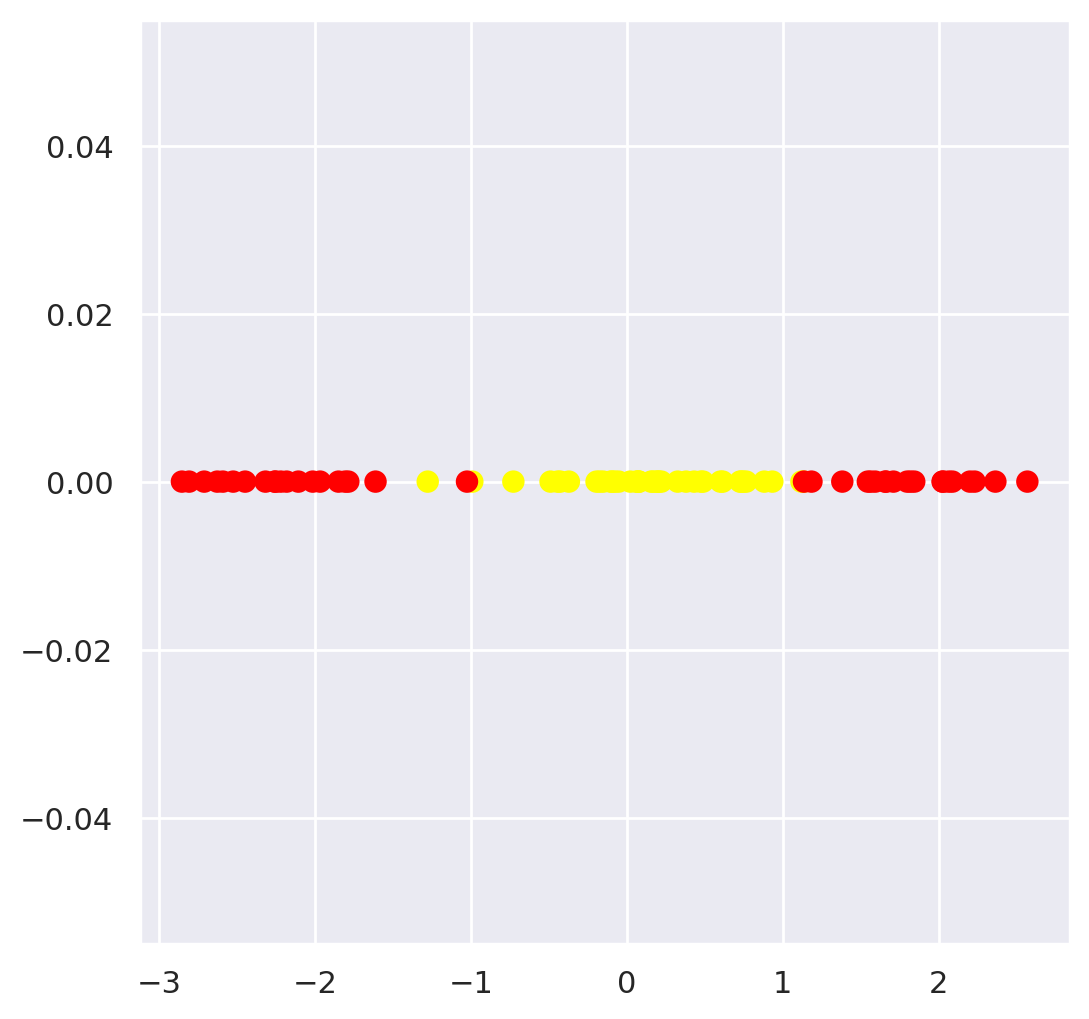

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize the random generator seed to compare results
np.random.seed(0)

# Generating artifial data
X0 = 0.5*np.random.randn(40,1)
Y0 = np.ones((40,))
X1 = 0.5*np.random.randn(20,1)-2
X2 = 0.5*np.random.randn(20,1)+2
Y12 = -np.ones((40,))

X = np.concatenate((X0,X1,X2))
y = np.concatenate((Y0,Y12))

plt.figure()
plt.scatter(X, np.zeros((80,)), c=y, s=50, cmap='autumn')
plt.show()

Let's plot different possibles solutions of a linear classifier:

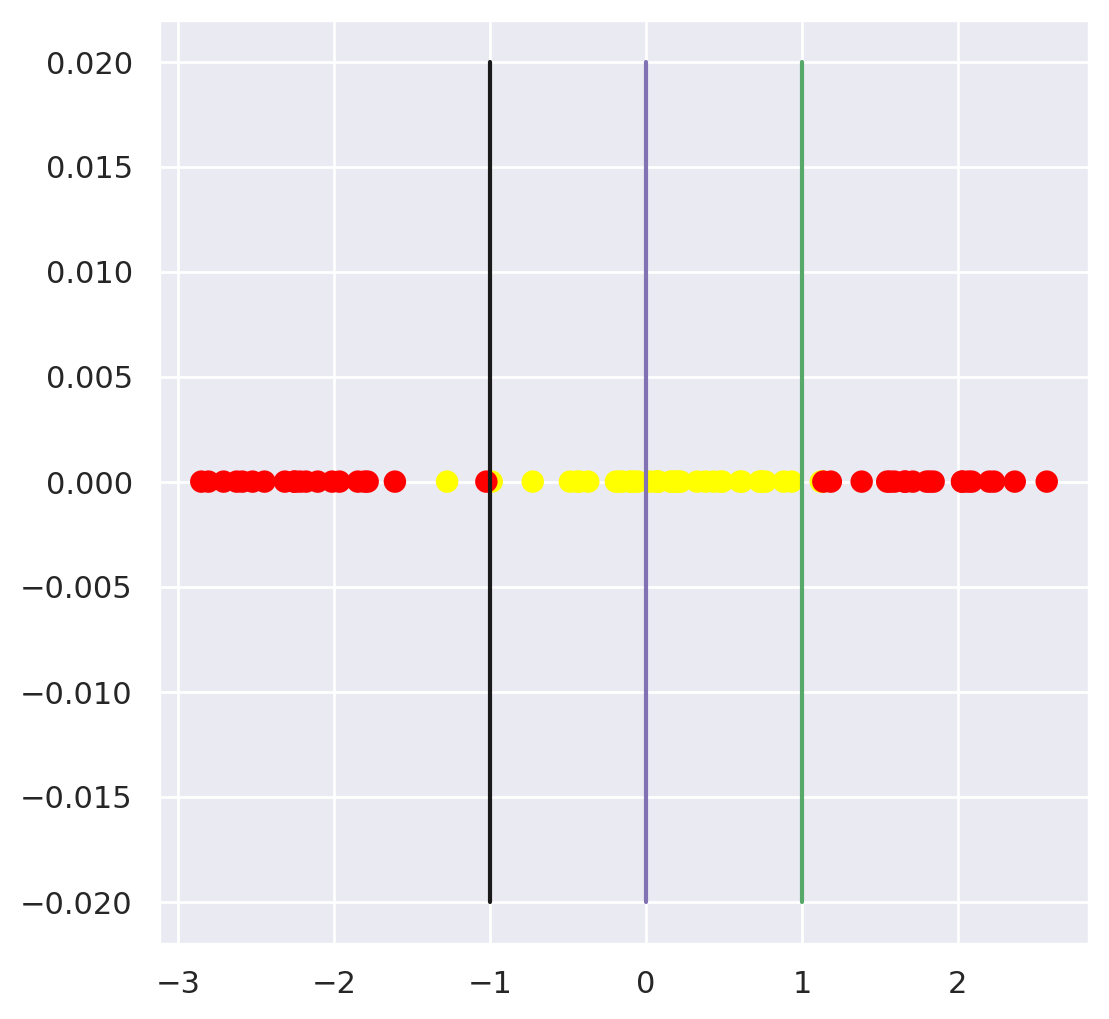

In [ ]:
plt.figure()

xfit = np.linspace(-0.02, 0.02)

plt.scatter(X, np.zeros((80,)), c=y, s=50, cmap='autumn')


m,b = (0, -1)
plt.plot( m * xfit + b,  xfit,'-k')

m,b = (0, 0)
plt.plot( m * xfit + b,  xfit,'-m')

m,b = (0, 1)
plt.plot( m * xfit + b,  xfit,'-g')


we can check that any of these solutions is suboptimal. However, we know that we can find a no-linear solution with a polynomial extension of the input features.

## Polynomial extension

We have also seen that we can use a non-linear transformation of the input features to generate a new set of features. For example, if we consider the above classification problem (with a single input feature), we can create a new set of features with polynomial extension of degree $2$ as follows

$${\bf \phi}(\mathbf{x}) = [x, x^2]$$
where $\phi()$ is the transformation function.



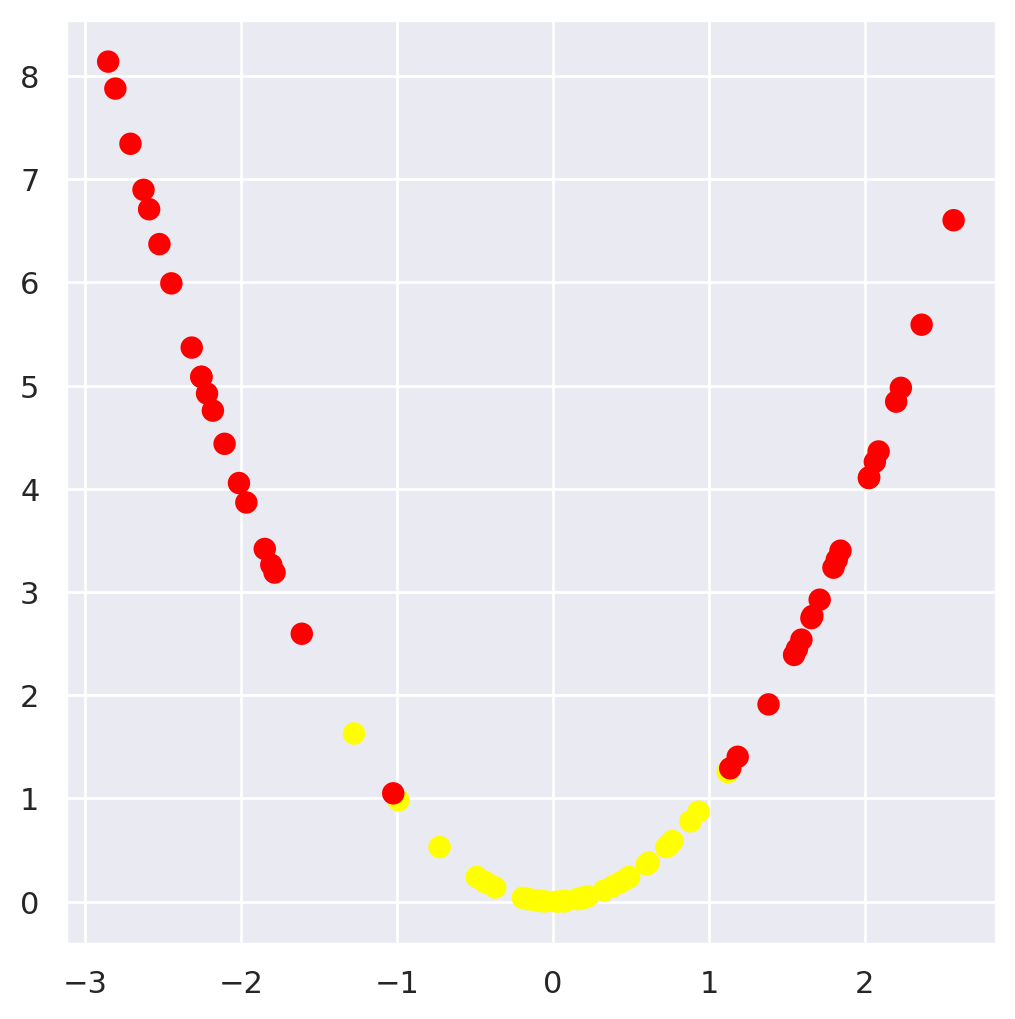

In [ ]:
# Let's create the polynomial extension
phiX = np.hstack((X, X**2))

plt.figure()
plt.scatter(phiX[:, 0], phiX[:, 1],  c=np.squeeze(y), s=50, cmap='autumn')
plt.show()


Now, we can use these new features to learn our linear model:

$$f(x) = w_0 +w_1 \phi_1(\mathbf{x}) + w_2 \phi_2(\mathbf{x}) = w_0 +w_1 x + w_2 x^2 $$

For example, we can train a linear SVM with these new features.


In [ ]:
from sklearn.svm import SVC # "Support vector classifier using the dual formulation"
model = SVC(kernel='linear', C=1)   # We use a linear kernel (no transformation), we will explain during next session.
                                       # Also, we explain below the role of C
model.fit(phiX, y)

SVC(C=1, kernel='linear')

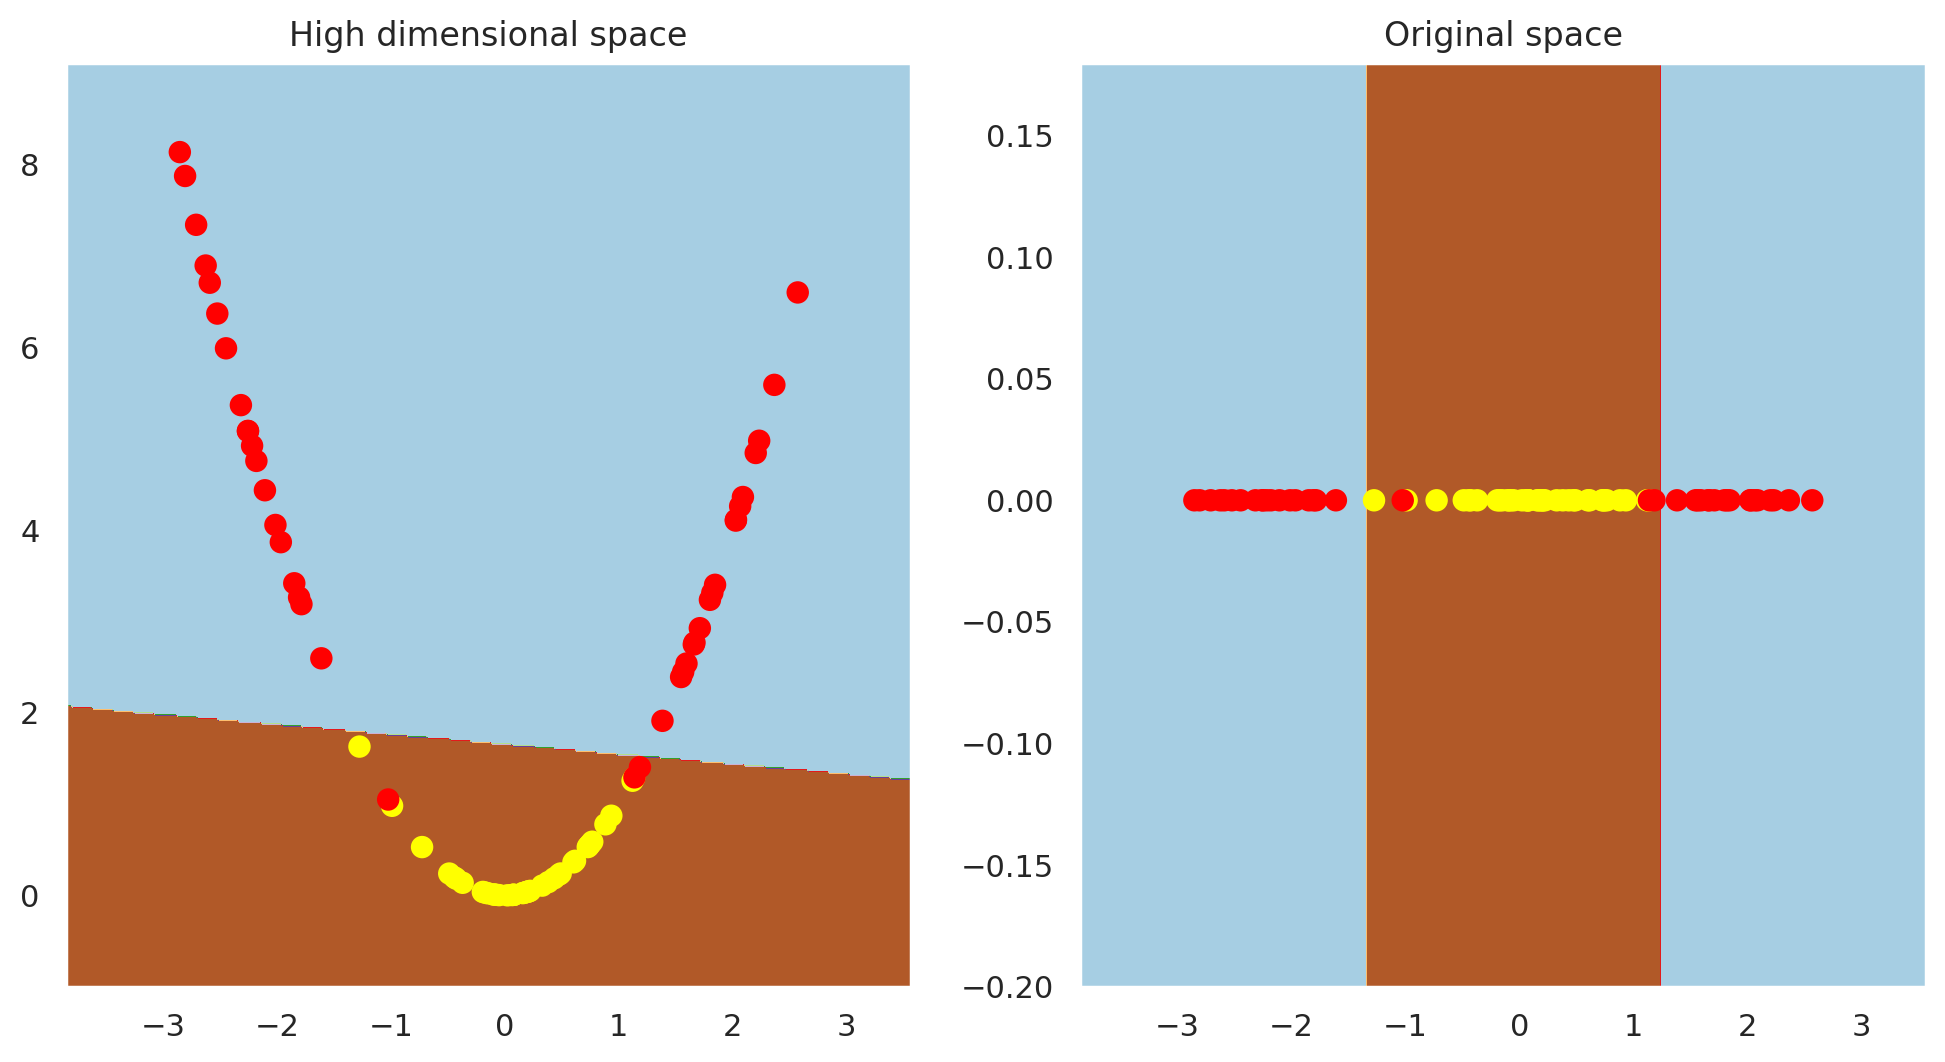

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)

plot_step = 0.02

x_min, x_max = phiX[:, 0].min() - 1, phiX[:, 0].max() + 1
y_min, y_max = phiX[:, 1].min() - 1, phiX[:, 1].max() + 1
XX, YY = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))


xy = np.vstack([XX.ravel(), YY.ravel()]).T
P = model.predict(xy).reshape(XX.shape)

plt.contourf(XX, YY, P, cmap=plt.cm.Paired)

plt.scatter(phiX[:, 0], phiX[:, 1], c=y, s=50, cmap='autumn')

plt.title('High dimensional space')

plt.subplot(1,2,2)


x_min, x_max = X[:, 0].min() - 1, phiX[:, 0].max() + 1
y_min, y_max = -0.2, 0.2
XX, YY = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))


xy = np.vstack([XX.ravel(), (XX**2).ravel()]).T
P = model.predict(xy).reshape(XX.shape)

plt.contourf(XX, YY, P, cmap=plt.cm.Paired)

plt.scatter(X, np.zeros((80,)), c=y, s=50, cmap='autumn')
plt.title('Original space')

plt.show()

We transform the data from 1D to 2D (feature transformation). We obtain a non-linear in the original space.


Note that $\phi()$ representes the transformation function able to project the data from a space of dimension $D=1$ to a higher dimension space (in this case, $D'=2$). So, our model is linear in this high dimensional space, but the provided solution is nonlinear in the original space. That is, **a nonlinear model can be constructed by a nonlinear transformation to a space of higher dimension**.

But, can we generalize the transformation function $\phi()$ to any (no-)linear transformation of our observations? The answer to this question is **yes** and we can do it by means of the **kernel functions**.

## Kernel functions

Let's consider a mapping function ${\bf \phi}(\mathbf{x})$ able to find a new representation of our data from the input space to a high dimesional space, called **feature space**

\begin{align}
\phi(\mathbf{x}): \mathbb{R}^D \rightarrow \mathbb{R}^{D'},
\end{align}

where $D'\geq D$.

The kernel function, $K(\cdot,\cdot)$, is just the inner product of two data points in this new feature space:

 $$K(\mathbf{x},\mathbf{x}') = <\phi(\mathbf{x}),\phi(\mathbf{x}')> = \phi(\mathbf{x})^T\phi(\mathbf{x}')$$


We can see that the kernel is a symmetric function of its arguments since $K(\mathbf{x},\mathbf{x}') = K(\mathbf{x}',\mathbf{x})$.


The concept of a kernel formulated as an inner product in a feature space allows us to build interesting extensions of many well-known algorithms by making use of the  **kernel trick**, also known as kernel substitution.

The general idea is that, if we have an algorithm formulated in such a way that the input vector $\mathbf{x}$ enters only in the form of scalar products, then we can firstly map the data to the feature space and we can later replace that scalar product in the feature space with the associated kernel funtion.












# 2. Kernel formulation of SVMs

**Dual formulation of the SVMs**

As we know, the dual SVM formulation is given by the following optimization problem: We have here the dot product of the input data x so can be applied the kernel method

\begin{align}
&\max_{\mathbf{a}}  ~~~~ \sum_{i=1}^{N}a^{(i)} -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a^{(i)} a^{(j)} y^{(i)} y^{(j)}\color{red}{{\mathbf{x}^{(i)}}^\top\mathbf{x}^{(j)}}\\
\text{s.t.} ~~~~ & 0\leq a^{(i)} \leq C, ~ i=1,\ldots,N\\
& 0  = \sum_{i=1}^{N} a^{(i)}  y^{(i)}
\end{align}

that can be solved by QP solver to find the optimum value of the dual parameters $\mathbf{a}$ and, then, we can predict future values as:
\begin{align}
f(\mathbf{x}^*) &= \sum_{i=1}^{N} a^{(i)} y^{(i)} \color{red}{{\mathbf{x}^{(i)}}^\top\mathbf{x}^*}+w_0
\end{align}
note that $f(\mathbf{x}^*) = \mathbf{w}^T\mathbf{x}^*+w_0$ and $\mathbf{w} =\sum_{i=1}^N a^{(i)} y^{(i)} \mathbf{x}^{(i)}$.



Both the optimization problem to find dual parameters and the estimation function are expressed in terms of inner products of the input data, so we can apply the **kernel trick** to obtain a no-linear SVM formulation.

**Formulation of the SVMs in the feature space**

If we project our data into a feature space by means of a mapping function ${\bf \phi}(\cdot)$, we can rewrite the SVM formulation as:

\begin{align}
&\max_{\mathbf{a}}  ~~~~ \sum_{i=1}^{N}a^{(i)} -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a^{(i)} a^{(j)} y^{(i)} y^{(j)}\color{red}{{{\bf \phi}(\mathbf{x}^{(i)})}^\top {\bf \phi}(\mathbf{x}^{(j)})}\\
\text{s.t.} ~~~~ & 0\leq a^{(i)} \leq C, ~ i=1,\ldots,N\\
& 0  = \sum_{i=1}^{N} a^{(i)}  y^{(i)}
\end{align}

Now, applying the **kernel trick**, we can newly rewrite this formulation as:

\begin{align}
&\max_{\mathbf{a}}  ~~~~ \sum_{i=1}^{N}a^{(i)} -\frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N a^{(i)} a^{(j)} y^{(i)} y^{(j)}\color{red}{K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})}\\
\text{s.t.} ~~~~ & 0\leq a^{(i)} \leq C, ~ i=1,\ldots,N\\
& 0  = \sum_{i=1}^{N} a^{(i)}  y^{(i)}
\end{align}

If I know the kernel of the combination training data I dont need the value of x. --> only know the kernel matrix!!!

Once dual parameters are obtained solving this new optimization problem, we can also apply the kernel trick over the prediction function to be able to classify new samples:
$$
f(\mathbf{x}^*) = \sum_{i=1}^{N} a^{(i)} y^{(i)} \color{red}{{{\bf \phi}(\mathbf{x}^{(i)})}^\top {\bf \phi}(\mathbf{x}^*)} +w_0 = \sum_{i=1}^{N} a^{(i)} y^{(i)} \color{red}{K(\mathbf{x}^{(i)},\mathbf{x}^*)}+w_0
$$

the only thing you need to make predictions I need is to compute the kernel between the support vector and the training data.

Note that this kernelized formulation has several advantages:

* A nonlinear SVM can be constructed by a nonlinear transformation to a higher dimension space (feature space). Then, we can find the maximum margin hyperplane that separates our training data in this feature space and, at the same time, finding a no-linear solution in the input space.

* The formulation is expressed in terms of the
kernel function. We don't even need to know the mapping function  ${\bf \phi}(\mathbf{x})$. It's enough to know all paired kernel values over the training data.

* If we wanted to recover the primal parameters ($\mathbf{w}$), the mapping function  ${\bf \phi}(\mathbf{x})$ should be known (which is not usually the case):
$$\mathbf{w} =\sum_{i=1}^N a^{(i)} y^{(i)} {\bf \phi}(\mathbf{x}^{(i)})$$
However, as we are using the formulation in terms of dual variables and kernel functions, this is not needed anymore.

* The output of the SVM can also be computed in terms of kernel functions. In this case we only have to compute the kernel between the new sample $\mathbf{x}^*$ and the training data. And, due to most $a^{(i)}$ values of the SVM solution are zero, it's enough to compute the kernel between the new sample $\mathbf{x}^*$ and the support vectors. Reducing the computational burden during the classification stage.

$$
f(\mathbf{x}^*) = \sum_{i \in SVs} a^{(i)} y^{(i)} K(\mathbf{x}^{(i)},\mathbf{x}^*)+w_0
$$

* The kernel can be understood as a similarity metric. So, vectors closest to $\mathbf{x}^*$ in the training set (in fact, only support vectors) are those that weight more in the prediction!




we don't need to know the mapping transformation only the dot product between the data I have. With kernels forget about knowing the "w" values because we need the mapping function

## Examples of kernel functions

In case we need to construct a kernel function, we could directly  choose  a feature space mapping $\phi(\mathbf{x})$. For instance, if ${x}\in\mathbb{R}$ we can choose the following transformation
\begin{align}
\phi(x) =[1, x, ~ x^2]
\end{align}

Then, the kernel function between two samples ${x}^{(1)}$ and ${x}^{(2)}$ is given by:
\begin{align}
k({x}^{(1)},{x}^{(2)}) = \phi(x^{(1)})^{\top} \phi(x^{(2)})= 1+ (x^{(1)}x^{(2)}) + \left(x^{(1)}x^{(2)}\right)^2
\end{align}

However, the most common approach to construct kernel functions is to **directly choose the kernel**. In this case, we must ensure that the function we choose **corresponds to a scalar product in some (perhaps infinite dimensional) feature space** (technically, that [Mercer's theorem](http://people.cs.uchicago.edu/~niyogi/papersps/MinNiyYao06.pdf) has to satisfied).

A very common kernel, that actually maps over an *infinite dimensional feature* space, is the **radial basis function (RBF) or Gaussian kernel**:

\begin{align}
k(\mathbf{x},\mathbf{x}') = \exp \left( -\frac{||\mathbf{x}-\mathbf{x}'||^2}{2\sigma^2} \right) = \exp \left( -\gamma ||\mathbf{x}-\mathbf{x}'||^2 \right)
\end{align}

where either $\sigma$ is called the bandwith and it is a hiperparameter that typically has to be adjusted by *cross validation*. Some implementions use an equivalent parameter $\gamma=\frac{1}{2\sigma^2}$.

Examples of other kernels are:
- Linear kernel:
$$k(\mathbf x_1, \mathbf x_2) = \mathbf x_1^\top \mathbf x_2$$
- Polinomial kernel:
$$k(\mathbf x_1, \mathbf x_2) = (\mathbf x_1^\top \mathbf x_2 + c)^d $$ with $d$ being the degree of the polynomial
- Exponentiation of a distance is a kernel
- Combinations of kernels are kernels


Check this [**link**](http://scikit-learn.org/stable/modules/metrics.html) to see possibles examples of kernels that can be used within sklearn.

the value of gamma have the opposite effect. Larger gamma peacky distribution

### Exercise 1

To analyze the advantages of this formultion, next cell generates a no-linear classification problem.

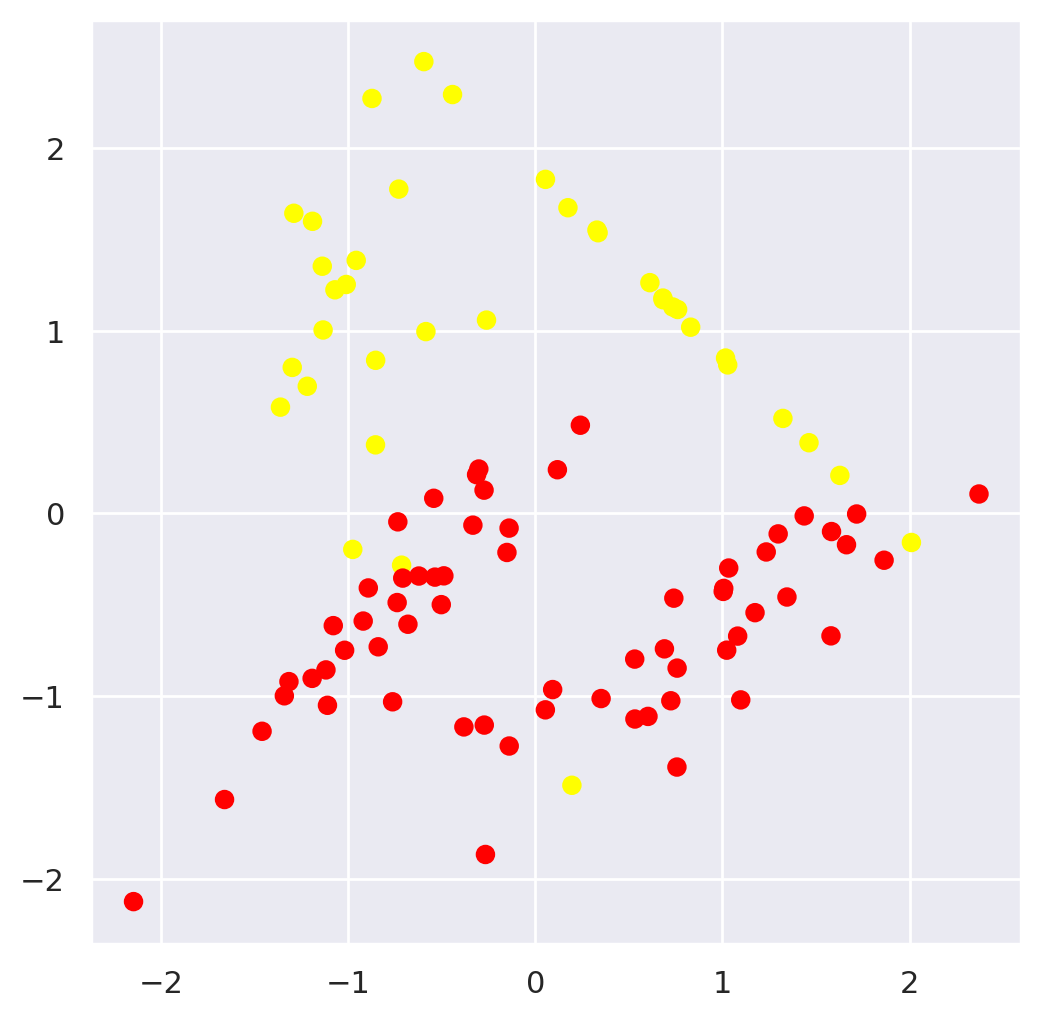

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize the random generator seed to compare results
np.random.seed(0)

# Generating artifial data
X, Y = datasets.make_classification(n_samples=500, n_features=2, n_classes = 2, n_clusters_per_class=2,
                                    class_sep=1.5, n_redundant=0, flip_y =0.01)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plt.show()

### Exercise 1.1 Linear SVM

Analyze the performance of a linear SVM over the above problem. For the sake of simplicity, you can use a default value of `C = 1`. Once the classifier is trained:
* Compute the accuracy over the test data
* Use the function `plot_svc_decision_function()` to plot the classification problem and the SVM solution (togheter to the support vectors).

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:            #If no figure handle is provided, it opens the current figure
        ax = plt.gca()

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)    #30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)                 # We create a grid with the x,y coordinates defined above

    # From the grid to a list of (x,y) values.
    # Check Numpy help for ravel()

    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    # In levels we provide a list of floating point numbers indicating
    #the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, marker='+')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

#### Solution

0.8875


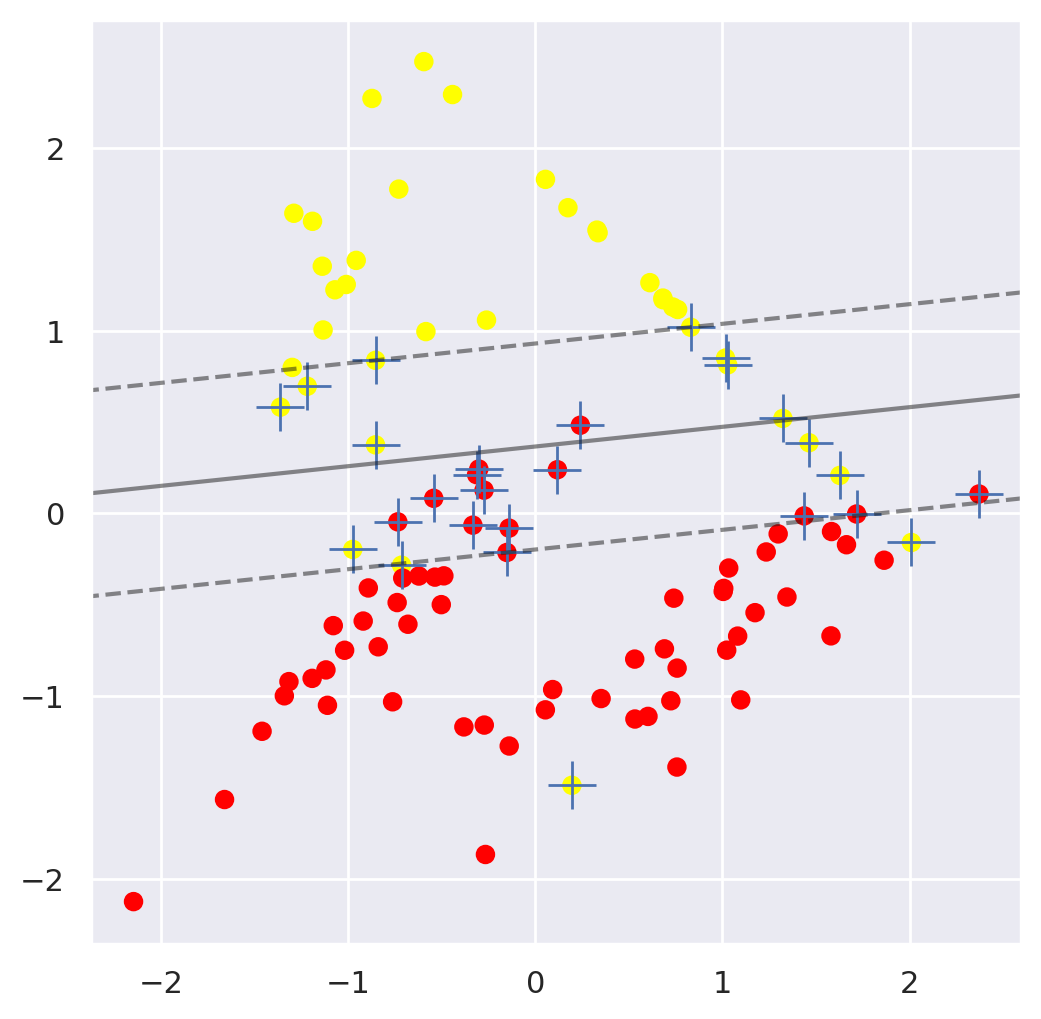

In [ ]:
#<SOL>
#</SOL>
C=1
from sklearn.svm import SVC # "Support vector classifier using the dual formulation"
model = SVC(kernel='linear', C=1)

model.fit(X_train,Y_train)

accuracy=model.score(X_test,Y_test)

print(accuracy)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plot_svc_decision_function(model)


### Exercise 1.2 RBF SVM

Train a no-linear SVM with a RBF kernel. Note that the [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) implementation let you define the kernel to be used together the kernel parameters. For simplicity, set `C=1` and explore different values of the `gamma` parameter `[0.01, 0.1, 1, 10, 100]`. Compute the test error and plot the classification boundary (and its margin) with `plot_svc_decision_function()` function.


#### Solution

0.83


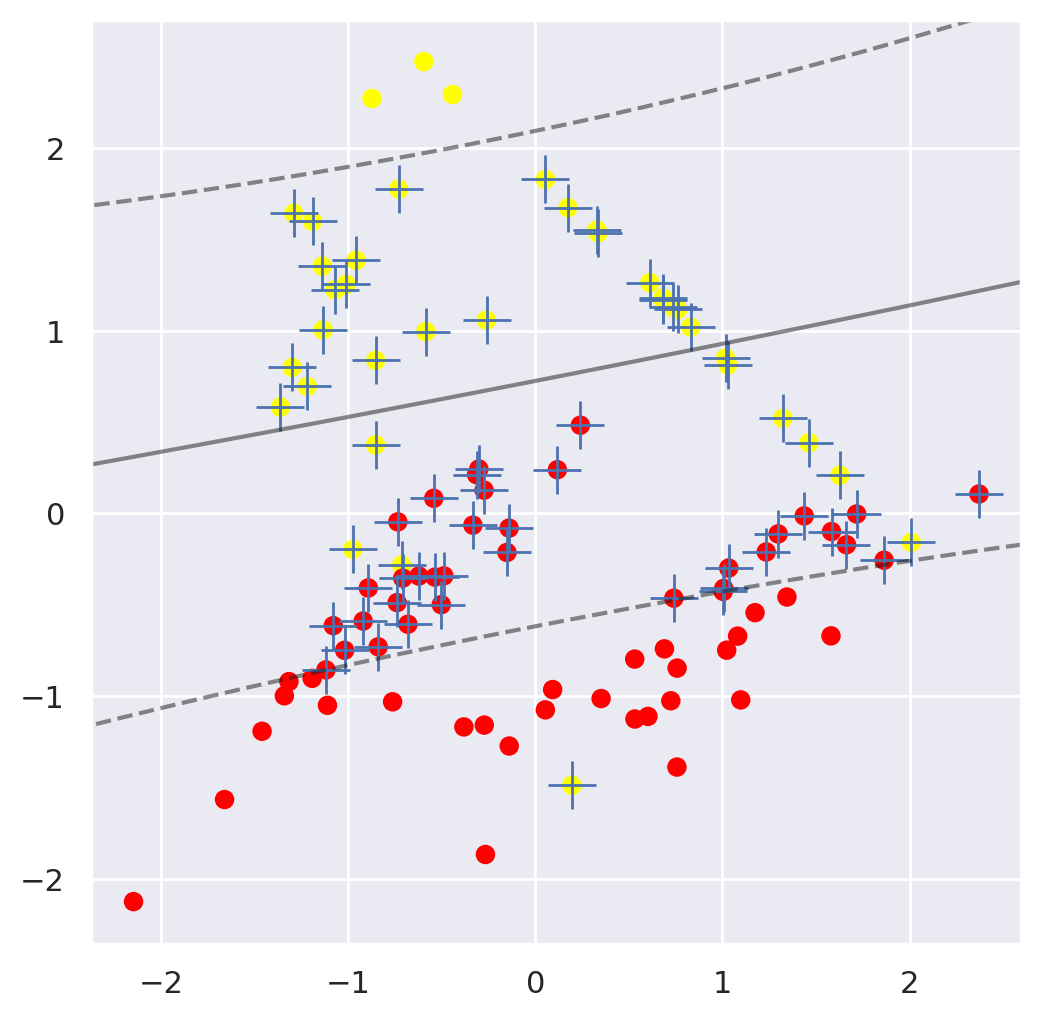

In [ ]:
#<SOL>
#</SOL>
C=1
gamma=[0.01,0.1,1,10,100]

model = SVC(kernel='rbf', C=1, gamma=gamma[0])
model.fit(X_train,Y_train)

accuracy_1=model.score(X_test,Y_test)
accuracy=model.score(X_test,Y_test)

print(accuracy)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plot_svc_decision_function(model)


0.885


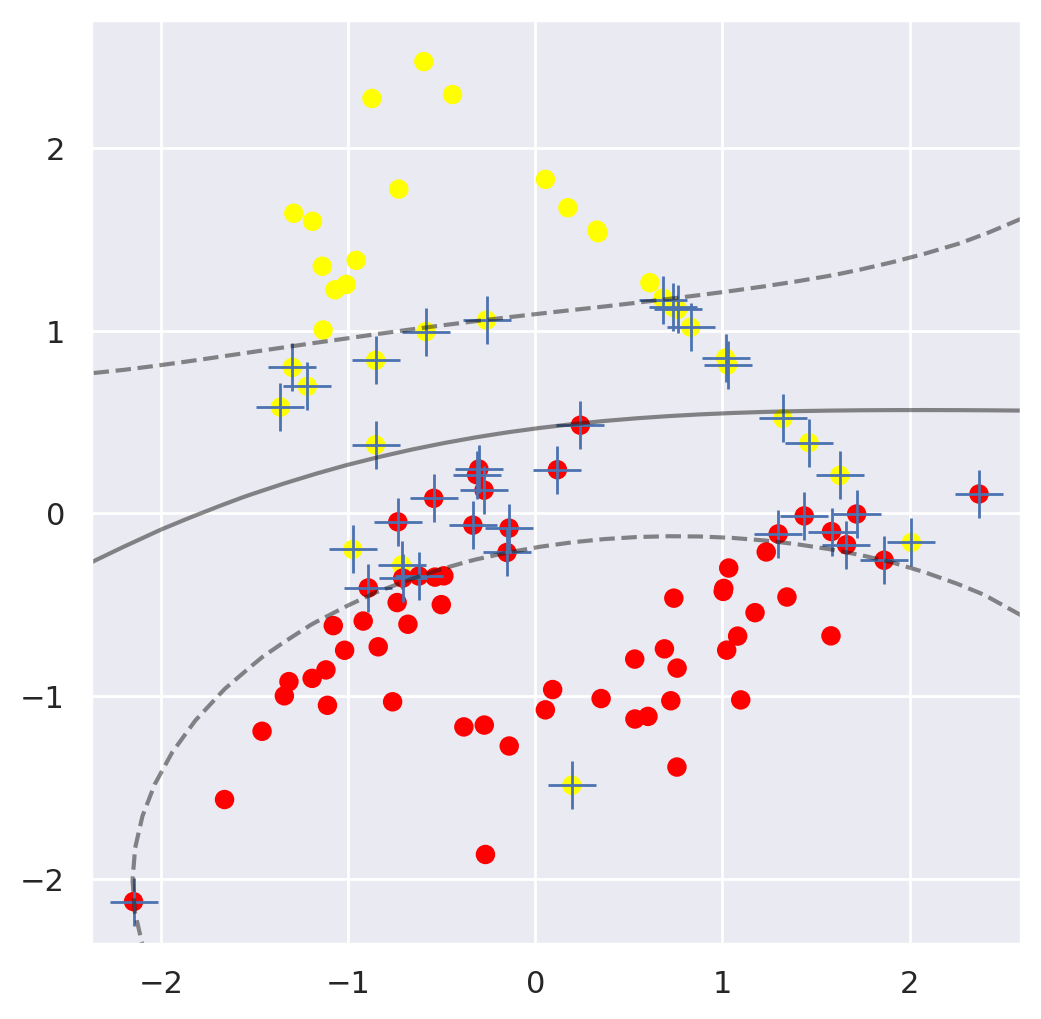

In [ ]:
#<SOL>
#</SOL>

model = SVC(kernel='rbf', C=1, gamma=gamma[1])
model.fit(X_train,Y_train)

accuracy_1=model.score(X_test,Y_test)
accuracy=model.score(X_test,Y_test)

print(accuracy)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plot_svc_decision_function(model)

0.9075


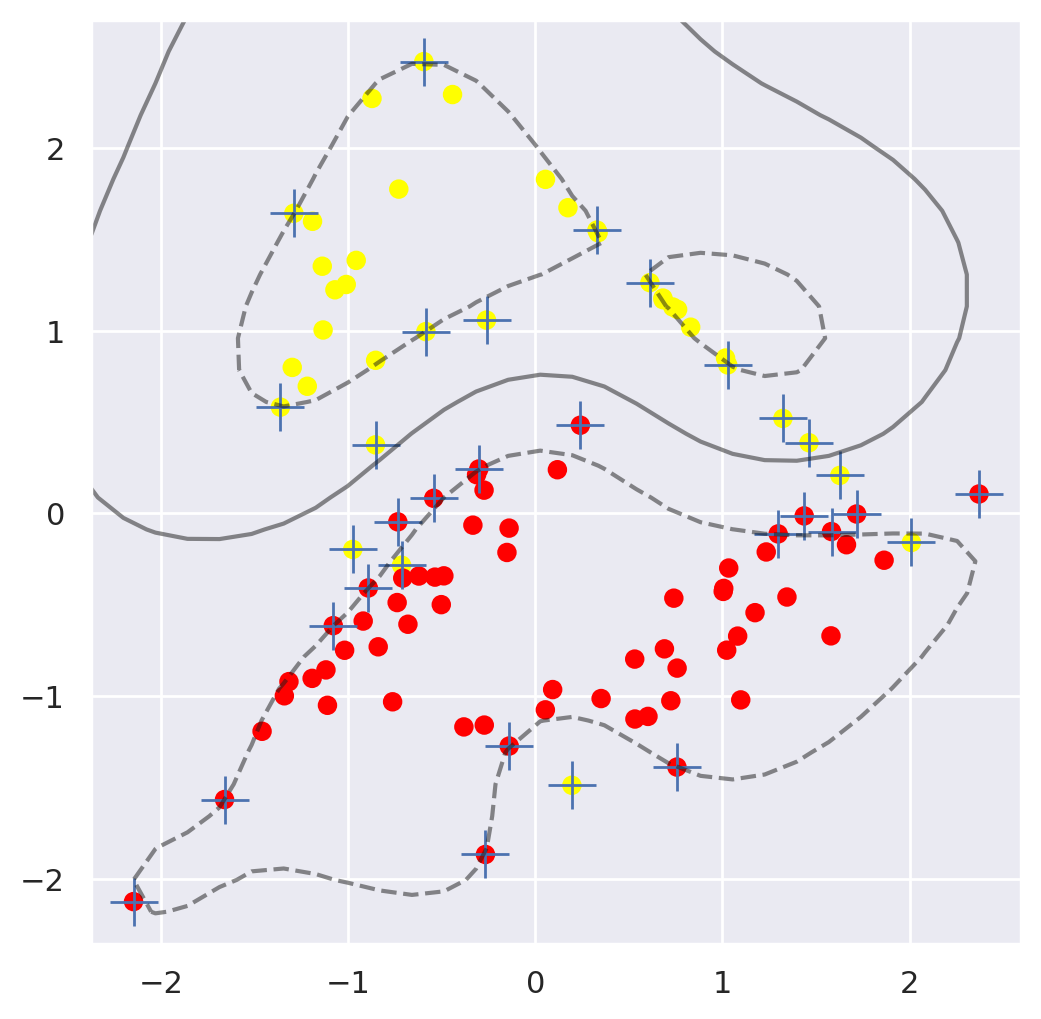

In [ ]:
#<SOL>
#</SOL>

model = SVC(kernel='rbf', C=1, gamma=gamma[2])
model.fit(X_train,Y_train)

accuracy_1=model.score(X_test,Y_test)
accuracy=model.score(X_test,Y_test)

print(accuracy)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plot_svc_decision_function(model)

0.9


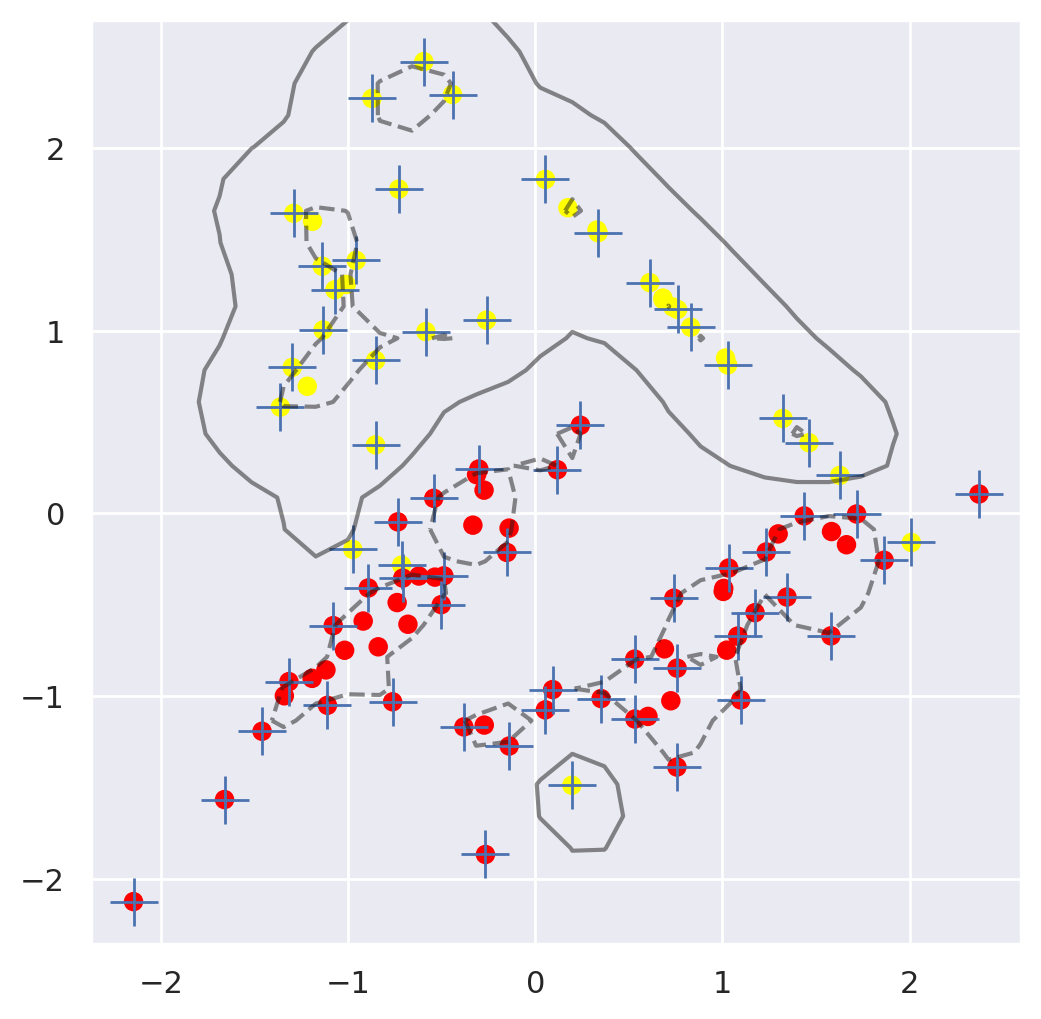

In [ ]:
model = SVC(kernel='rbf', C=1, gamma=gamma[3])
model.fit(X_train,Y_train)

accuracy_1=model.score(X_test,Y_test)
accuracy=model.score(X_test,Y_test)

print(accuracy)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plot_svc_decision_function(model)

0.7275


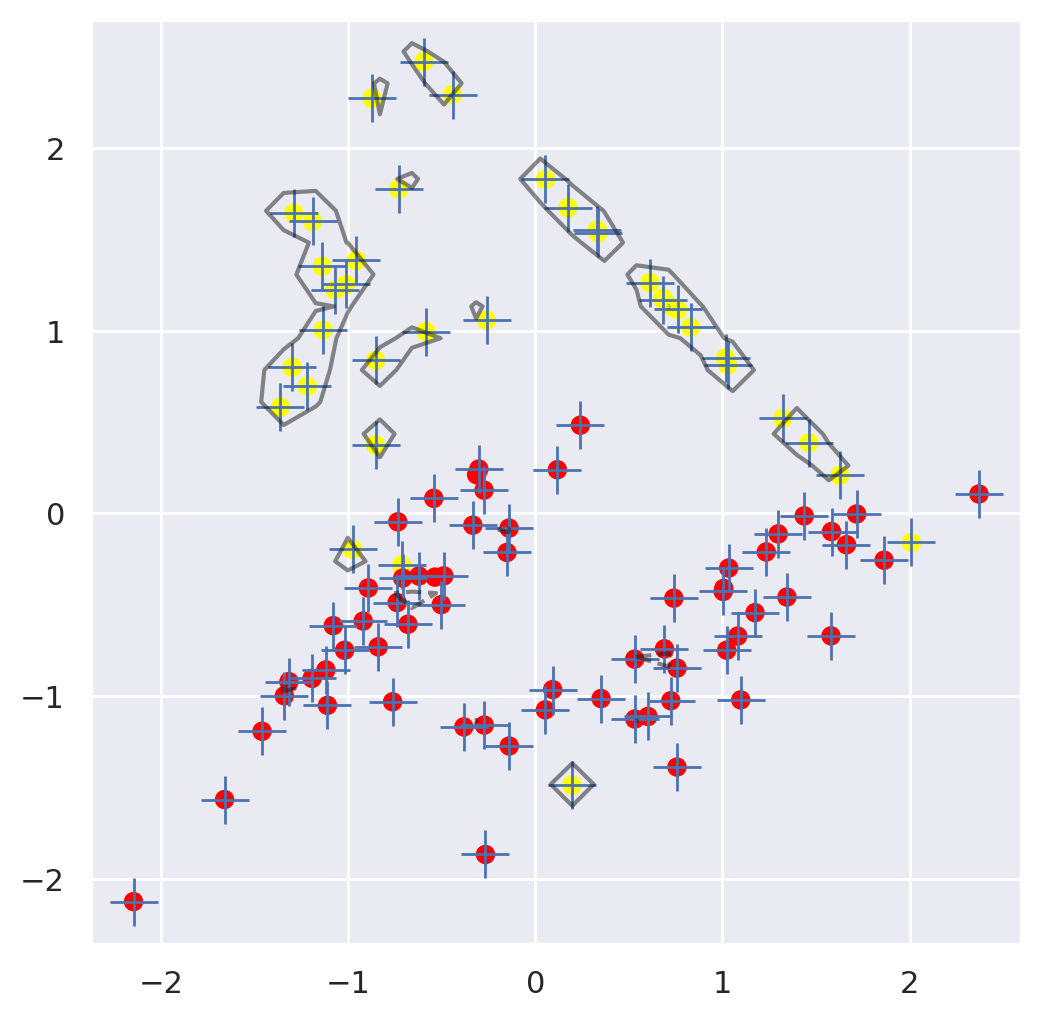

In [ ]:
model = SVC(kernel='rbf', C=1, gamma=gamma[4]) # everything is support vector --> overfitting
model.fit(X_train,Y_train)

accuracy_1=model.score(X_test,Y_test)
accuracy=model.score(X_test,Y_test)

print(accuracy)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plot_svc_decision_function(model)

### Exercise 1.3 Analyze these results

In the light of the results try to answer the following questions:
* Why do small values of $\gamma$ (or large values of the RBF bandwidth) tend to provide linear solutions?.
* Why do large values of $\gamma$ (or small values of the RBF bandwidth) tend overfit?.


#### Answer

When γ is small, it means that the RBF kernel has a large bandwidth, which makes the similarity between data points decrease more slowly with distance. A larger RBF bandwidth means that the influence of each training example on the decision boundary is more widespread.

 when γ is large, the RBF kernel has a smaller bandwidth, causing the similarity between data points to decrease rapidly with distance. A smaller RBF bandwidth means that the influence of each training example is highly localized, and the model becomes more sensitive to individual data points.

 In summary, small values of γ make the SVM model more robust and tend to provide simpler, linear solutions because they focus on capturing broader patterns in the data. On the other hand, large values of γ make the model more sensitive to individual data points, potentially leading to overfitting as it tries to fit the training data very closely, including noise

low gamma--> wide gaussian--> similar way as the linear solution

high gamma --> peaky gaussian. everything is gonna be support vector and overfit. Bad generalization

### Exercise 1.3 RBF SVM: parameter selection

Use a 5-fold CV process to adjust both $C$ and $\gamma$ parameters of a RBF SVM. Explore 10 values of $C$ from $0.001$ to $1000$, logarithmic equispaced, and define the range of $\gamma$ as: $[0.125, 0.25, 0.5, 1, 2, 4, 8])/D$,
being $D$ the data dimension. Note that this definition of the $\gamma$ values is used alleviate the influence of the data dimension in the definition of the RBF kernel.

Again, you can plot the final classification boundary and compute the test error to analyze the results.


why dividing D?

the larger is the input data the more is the distance. In a high dimensional use this and compensate and no matter about the dimension of your data

#### Solution

In [ ]:
#<SOL>
#</SOL>
from sklearn.model_selection import GridSearchCV

num_features=np.shape(X_train)[1]
gamma_values = [val / num_features for val in [0.125, 0.25, 0.5, 1, 2, 4, 8]]

parameters = {'gamma':gamma_values, 'C':np.logspace(-3, 3, 10)}
svc = SVC(kernel='rbf')
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, Y_train)

print("Best gamma:", clf.best_params_['gamma'])
print("Best C:", clf.best_params_['C'])

Best gamma: 2.0
Best C: 0.46415888336127775


0.9075


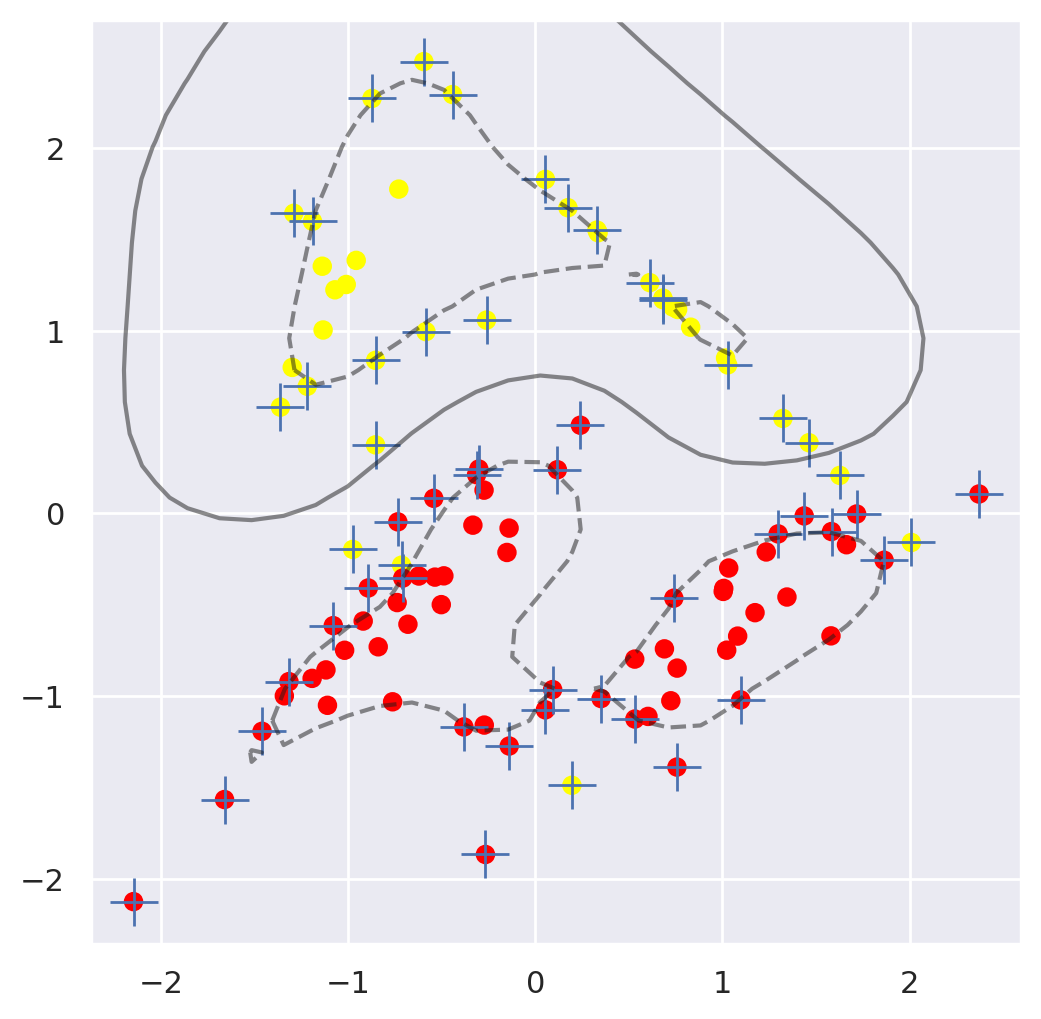

In [ ]:
model = SVC(kernel='rbf', C=clf.best_params_['C'], gamma=clf.best_params_['gamma'])
model.fit(X_train,Y_train)

accuracy_1=model.score(X_test,Y_test)
accuracy=model.score(X_test,Y_test)

print(accuracy)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='autumn')
plot_svc_decision_function(model)

## Representer Theorem

**Can we extend the kernel formulation to other linear methods?**


The answer to this question is given by the [**Representer Theorem**](https://en.wikipedia.org/wiki/Representer_theorem) which, in simple terms, says that the solution of any algorithm obtained by the minimization of a regularized empirical cost can be represented as a weigthed linear combination of the training data.


So, if we are working with a linear algorithm

$$
f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}
$$

and we learn the weights $\mathbf{w}$ of this model by minimizing any regularized empirical cost function:

$$\mathbf w^* =\displaystyle \underset{\bf{w}}{\operatorname{min}} \sum_{i=1}^N    L \left( f( {\mathbf x}^{(i)}) , y^{(i)} \right) + \lambda \Vert \mathbf{w} \Vert^2 $$  

where $L \left( \cdot, \cdot \right)$ is the cost function (for instance, the binomial deviance in logistic regression or the MSE in linear regression); then, the Representer Theorem assures us that the parameters of the lineal model are a linear combination of the training data
$$\mathbf{w} =\sum_{i=1}^N a^{(i)} \mathbf{x}^{(i)}$$
and
$$
f(\mathbf{x}^*) = \sum_{i=1}^{N} a^{(i)} {\mathbf{x}^{(i)}}^{\top}\mathbf{x}^*
$$

Even, in case that we are working over the feature space generated by a mapping function $\phi(\mathbf{x})$, we can say that the algorithm output is given by are a linear combination of kernel functions (inner products in this feature space)
$$
f(\mathbf{x}^*) = \sum_{i=1}^{N} a^{(i)}  K(\mathbf{x}^{(i)},\mathbf{x}^*)
$$
and now the goal of the model training (or inference) is learning these dual variables $a^{(1)}, \ldots, a^{(N)}$.

So, **if an algorithm fits the Representer Theorem, a dual expression
can be constructed as function of dot products (or kernel functions) between data**.


## Kernel Ridge Regression (linear regression with a regularization term)


### Ridge linear regression model in the feature space

Consider we have a **training** database of $N$ entries of the form $(\mathbf{x}^{(i)},y^{(i)})$, where $\mathbf{x}^{(i)}\in\mathbb{R}^D$ and $y^{(i)}\in\mathbb{R}$. Now, imagine that each of the input vectors is transformed into a **feature vector** as

\begin{align}
\phi(\mathbf{x}): \mathbb{R}^D \rightarrow \mathbb{R}^{D'},
\end{align}

where $D'\geq D$. We will use this training set to fit a model (in the feature space) of the form

$$f(\mathbf{x}) = \theta_0 + \theta_1 \phi(\mathbf{x})_1 + \theta_2 \phi(\mathbf{x})_2 + \ldots + \theta_{D'} \phi(\mathbf{x})_{D'} $$
note that theta is like w and the first element  of $\phi(\mathbf{x})$ is $1$, i.e. $\phi(\mathbf{x})_0=1$, so that it accomodates the intercept. And, the optimal values of $\boldsymbol{\theta}$ have to be found minimizing the **ridge loss function**:
$$ L(\boldsymbol{\theta},\lambda) = \frac{1}{N} \left[\sum_{i=1}^{N} (y^{(i)}-\boldsymbol{\theta}^T\phi(\mathbf{x}^{(i)}))^2 + \lambda \sum_{j=1}^{D'} \theta_j^2\right]
$$


### The dual problem representation

As this model satifies the Representer Theorem (it minimizes a regularized empirical cost), we know that the optimal solution ($\boldsymbol{\theta}^*)$ can be expressed as a **linear combination of the mapped training data**

\begin{align}
\boldsymbol{\theta}^* = \sum_{i=1}^{N} a^{(i)} \phi(\mathbf{x}^{(i)}) = \mathbf{\Phi}^T\mathbf{a},
\end{align}

Thus, given $\mathbf{a}$, the regression estimate for a new vector $\mathbf{x}^{*}$ is:

\begin{align}
f(\mathbf{x}^*) =  \sum_{i=1}^{N} a^{(i)} k(\mathbf{x}^{(i)},\mathbf{x}^*)
\end{align}


### Finding the vector of coefficients $\mathbf{a}$

If we substitute $\mathbf{\theta} = \mathbf{\Phi}^T\mathbf{a}$ in the Ridge Loss function we get the dual optimization problem. After some manipulation, the loss function is expressed in the following way:

\begin{align}
L(\mathbf{a},\lambda) = \frac{1}{N}\left[\mathbf{a}^T \mathbf{K}^T\mathbf{K}\mathbf{a}-2\mathbf{a}^T\mathbf{K}\mathbf{y}+\lambda\mathbf{a}^T\mathbf{K}\mathbf{a}\right],
\end{align}
where $\mathbf{K}$ is the $(N\times N)$ symmetric **kernel matrix** such that the element $(n,m)$ is
$$
k_{nm} = k(\mathbf{x}^{(m)},\mathbf{x}^{(n)}).
$$

$L(\mathbf{a},\lambda)$ is a convex function whose minimum is attained at
$$\mathbf{a} = \left(\mathbf{K}+\lambda \mathbf{I}\right)^{-1} \mathbf{y}.$$
Note that:
* The complexity (to obtain the dual variables) now increases as $\mathcal{O}(N^3)$ instead of the $\mathcal{O}(D^3)$ complexity that we had in the  primal space.
* The obtained solution is **not sparse** (in general, $\mathbf{a}$ values are not zero), unlike SVM solution; so, the estimation function
\begin{align}
f(\mathbf{x}^*) =  \sum_{i=1}^{N} a^i k(\mathbf{x}^{(i)},\mathbf{x}^*)
\end{align}
will need to compute all the kenels between all training data and the test sample to estimate its ouput.



here unlike SVM is that we have to apply the kernel to all the training data!!!

### Exercise 2

Consider the following regression problem where a `sinc()` function has to be modeled.

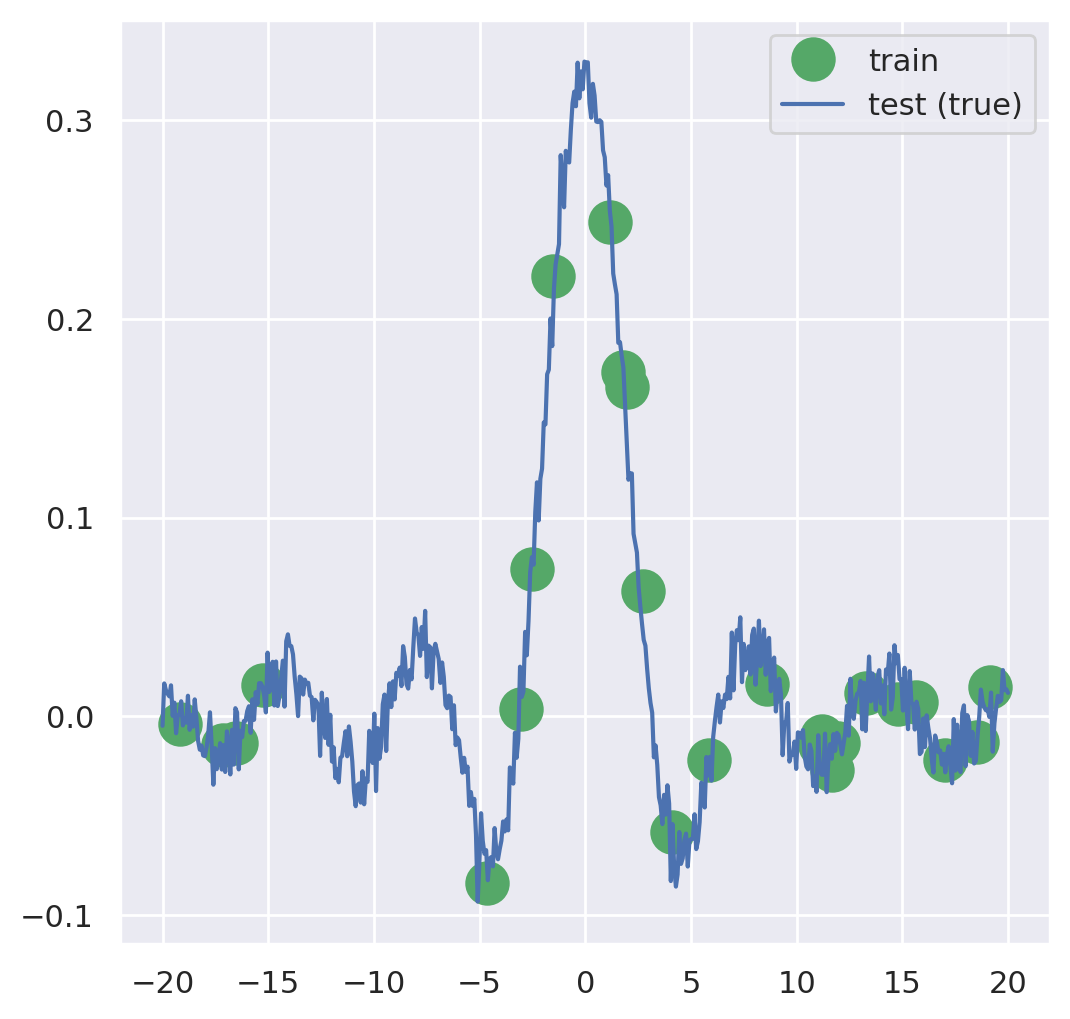

In [ ]:
np.random.seed(0)

N_train = 25
R = 20
Xtrain = np.sort(np.random.uniform(-R,R,N_train), axis=0)       #Training points

Xtest = np.linspace(-R,R,500)      #Test points

def noise_sinc(X):
    Y = np.sin(X)/np.pi/(X+1e-6) + np.sqrt(1e-04) * np.random.randn(X.shape[0])
    return Y

Ytrain = noise_sinc(Xtrain)
Ytest = noise_sinc(Xtest)

Xtrain = Xtrain[:, np.newaxis] #Define 2-dimensional data (.fit does not work with 1-dimensional vectors)
Xtest = Xtest[:, np.newaxis]

plt.figure()
plt.plot(Xtrain,Ytrain,'go',ms=15,label='train')
plt.plot(Xtest,Ytest,'b-',label='test (true)')
plt.legend()
plt.show()

Now, train a kernel ridge linear regression (KRR) with a RBF kernel to estimate the `sinc()` function (you can start with its default parameters). Once the model has been trained:
* Analyze how does the kernel regressor behave as you vary either the number of training points, the alpha ($\lambda$) parameter, the bandwith in the RBF kernel ($\gamma$).
* How do you identify that the model is overfitting? or if the model is too biased? how do you regularize?
* Investigate also the effect of varying the kernel (linear, polynomial, ...)

You can use [**sklearn implementation of KRR**](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge)



#### Solution

In [ ]:
#<SOL>
#</SOL>
from sklearn.kernel_ridge import KernelRidge


clf = KernelRidge(alpha=0.01, kernel='rbf', gamma=0.1)
# alpha 100 we allow errors, alpha 0.01 no errors are allowed
# gamma 0.01 linear, 100 overfitted
# alpha=0.01 and gamma=0.1 is working pretty well
clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)

plt.plot(Xtrain,Ytrain,'go',ms=15,label='train')
plt.plot(Xtest,Ypred,'r*',ms=5,label='KRR')
plt.plot(Xtest,Ytest,'b-',label='test (true)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Kernel Logistic Regression (KLR)

We can also kernelize the formulation of the Logistic Regression classifier. As this algorithm is minimizing the regularized binomial deviance:

$$ L(\bf{w}) = \sum_{i=1}^N \left\lbrace   \log \left( 1+ \exp({\bf w}^T {\bf x}^{(i)})\right) \right\rbrace  -y^{(i)} ({\bf w}^T {\bf x}^{(i)}) + \lambda \Vert {\bf w} \Vert_2^2$$

it also satisfies the Representer Theorem, then we can claim that

$$\mathbf{w} =\sum_{i=1}^N a^{(i)} \mathbf{x}^{(i)}$$

So, we can find a dual representation of this cost function in a feature space as:
$$ L(\bf{a}) = \sum_{i=1}^N \left\lbrace   \log \left( 1+ \exp(\mathbf{a}^T \bf{k}(\mathbf{x}^{(i)})\right) \right\rbrace  -y^{(i)} \mathbf{a}^T \bf{k}(\mathbf{x}^{(i)}) + \lambda\mathbf{a}^T\mathbf{K}\mathbf{a}$$

where $\mathbf{K}$ is the $(N\times N)$ symmetric training kernel matrix and $\mathbf{k}(\mathbf{x}^{(i)})$ is a column vector $(N\times 1)$ with all the kernels between the training data and the data $\mathbf{x}^{(i)}$.

The KLR optimization problem is usually solved by gradient descend. However, its implementation is not included in sklearn as, for kernel methods in classification, sparse kernel machines like Support Vector Machines are preferred.

Not sparse --> no one use it because you usually use the SVM


